In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
bank = pd.read_csv("bank_processed.csv")

In [3]:
bank.head()

,Unnamed: 0,age,job,marital,education,default,housing,loan,contact,month,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,FinalOutcome
0,0,56,housemaid,married,basic.4y,no,no,no,telephone,may,...,1,0,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
1,1,57,services,married,high.school,unknown,no,no,telephone,may,...,1,0,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
2,2,37,services,married,high.school,no,yes,no,telephone,may,...,1,0,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
3,3,40,admin.,married,basic.6y,no,no,no,telephone,may,...,1,0,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
4,4,56,services,married,high.school,no,no,yes,telephone,may,...,1,0,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0


In [13]:
bank.contact

0        telephone
1        telephone
2        telephone
3        telephone
4        telephone
           ...    
36187     cellular
36188     cellular
36189     cellular
36190     cellular
36191     cellular
Name: contact, Length: 36192, dtype: object

In [5]:
#bank_prescription = pd.get_dummies(bank, columns = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'day_of_week', 'month', 'poutcome'], drop_first = True)
bank = pd.get_dummies(bank, columns = ['contact','job', 'marital', 'education', 'default', 'housing', 'loan', 'day_of_week', 'month', 'day_of_week', 'poutcome'], drop_first = True)

In [6]:
bank=bank.drop(['duration'],axis=1)
#bank_presc=bank_presc.drop(['duration'],axis=1)

In [26]:
#bank.to_csv('bank_processed.csv')

# Modelling

In [7]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, accuracy_score,f1_score
from sklearn.metrics import classification_report
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold

In [8]:
model_comparison={}

In [16]:
X=bank.drop(['FinalOutcome'],axis=1)
y=bank['FinalOutcome']

In [32]:
#bank_presc['contact'] = bank['contact'].apply(lambda x: "email" if x=="telephone" else x )

In [33]:
#bank_presc.to_csv("bank_presc_final.csv")

In [39]:
#bank.to_csv("bank_trees.csv")


In [10]:
X.values

array([[0, 56, 'telephone', ..., 0, 1, 0],
       [1, 57, 'telephone', ..., 0, 1, 0],
       [2, 37, 'telephone', ..., 0, 1, 0],
       ...,
       [41185, 56, 'cellular', ..., 0, 1, 0],
       [41186, 44, 'cellular', ..., 0, 1, 0],
       [41187, 74, 'cellular', ..., 0, 0, 0]], dtype=object)

## Feature Selection Using the ExtraTreesClassifier

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel
clf = ExtraTreesClassifier(n_estimators=100, random_state = 0)
clf = clf.fit(X.values, y)
clf.feature_importances_  
model = SelectFromModel(clf, prefit=True)
X_new = model.transform(X.values)

In [18]:
feature_idx = model.get_support()
feature_name = X.columns[feature_idx]

In [21]:
## Features that were selected
feature_name

Index(['Unnamed: 0', 'age', 'campaign', 'pdays', 'emp.var.rate',
       'cons.conf.idx', 'euribor3m', 'nr.employed', 'marital_married',
       'housing_yes', 'loan_yes', 'poutcome_success'],
      dtype='object')

In [24]:
X_new.shape

(36192, 12)

In [22]:
### Train / Test Split
X_train,X_test,y_train,y_test=train_test_split(X_new,y,test_size=0.25,stratify=y,random_state=0)
#X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.25,stratify=y,random_state=0)

In [23]:
### Scaling the features

from sklearn.preprocessing import StandardScaler
sc=StandardScaler()
X_train=sc.fit_transform(X_train)
X_test=sc.transform(X_test)

In [25]:
X_train.shape

(27144, 12)

In [26]:
from sklearn.metrics import confusion_matrix, accuracy_score,classification_report,balanced_accuracy_score,roc_auc_score
from sklearn.model_selection import GridSearchCV

## Decision Trees

In [27]:
parameters = {'criterion':('gini', 'entropy'), 'max_depth':[3,4,5], 'min_samples_leaf':[100,200,300,400], 'ccp_alpha':[0.000241401] }
dtclassifier=DecisionTreeClassifier(random_state = 0)
clf = GridSearchCV(dtclassifier, parameters, scoring = 'roc_auc', cv=5)
clf.fit(X_train,y_train)
y_pred=clf.predict(X_test)
print(f"Model AUC : {roc_auc_score(y_pred,y_test, average='micro')*100:.2f}%")
print(f"Model Balanced Accurary : {balanced_accuracy_score(y_pred,y_test)*100:.2f}%")
print(f"Model Accuracy : {accuracy_score(y_pred,y_test)*100:.2f}%")
print(f"Model F1-Score : {f1_score(y_pred,y_test,average='weighted')*100:.2f}%")
print(classification_report(y_pred,y_test,zero_division=1))
model_comparison['Decision Tree']=[roc_auc_score(y_pred,y_test, average='micro'), balanced_accuracy_score(y_pred,y_test), accuracy_score(y_pred,y_test),f1_score(y_pred,y_test,average='weighted')]

Model AUC : 77.90%
Model Balanced Accurary : 77.90%
Model Accuracy : 89.24%
Model F1-Score : 91.76%
              precision    recall  f1-score   support

           0       0.98      0.90      0.94      8699
           1       0.21      0.66      0.32       349

    accuracy                           0.89      9048
   macro avg       0.60      0.78      0.63      9048
weighted avg       0.96      0.89      0.92      9048



In [28]:
clf.best_params_

{'ccp_alpha': 0.000241401,
 'criterion': 'entropy',
 'max_depth': 5,
 'min_samples_leaf': 100}

In [30]:
## Training with the best parameters

dtclassifier=DecisionTreeClassifier(criterion='entropy', max_depth=5, random_state=0)
dtclassifier.fit(X_train,y_train)
y_pred=dtclassifier.predict(X_test)
print(f"Model AUC : {roc_auc_score(y_pred,y_test, average='micro')*100:.2f}%")
print(f"Model Balanced Accurary : {balanced_accuracy_score(y_pred,y_test)*100:.2f}%")
print(f"Model Accuracy : {accuracy_score(y_pred,y_test)*100:.2f}%")
print(f"Model F1-Score : {f1_score(y_pred,y_test,average='weighted')*100:.2f}%")

Model AUC : 78.37%
Model Balanced Accurary : 78.37%
Model Accuracy : 89.37%
Model F1-Score : 91.75%


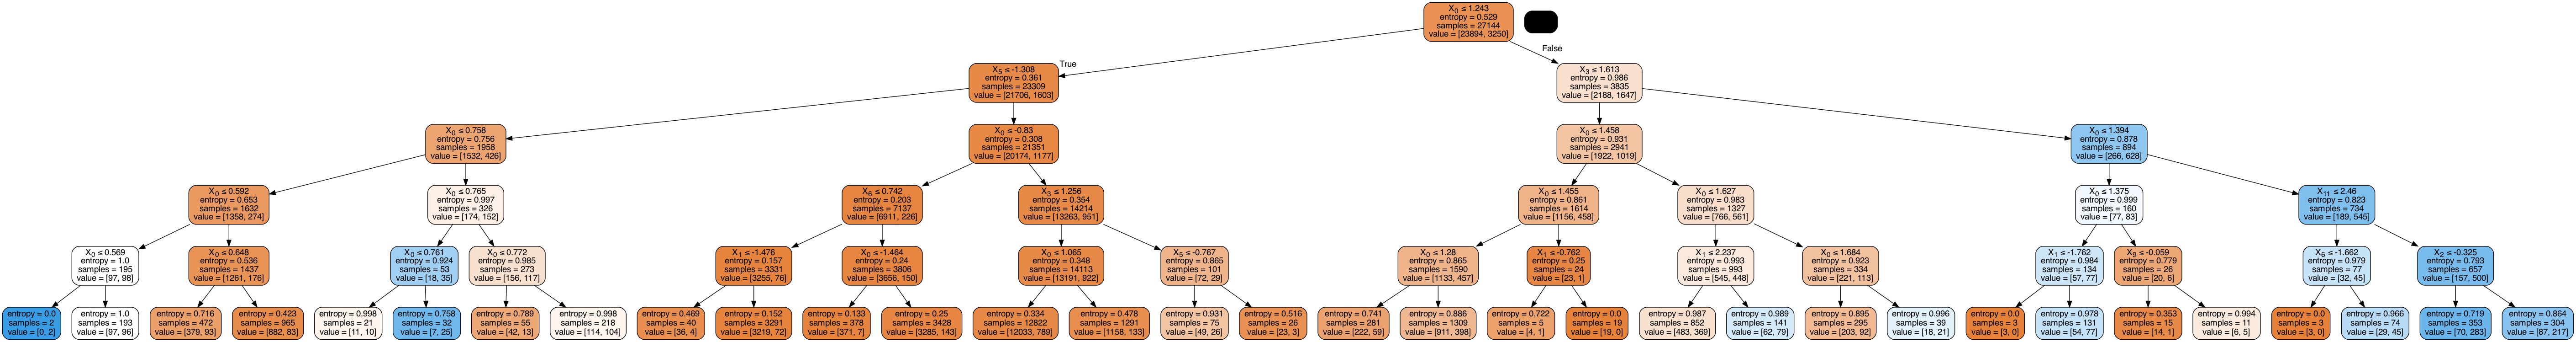

In [31]:
## Depiction of the best tree

from six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

dot_data = StringIO()
export_graphviz(dtclassifier, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True)

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

## Logistic Regression Rest

In [32]:
parameters = {'penalty':['none', 'l1', 'l2','elasticnet']}
lrclassifier=LogisticRegression(random_state=0)
clf = GridSearchCV(lrclassifier, parameters, scoring='roc_auc', cv=5)
clf.fit(X_train,y_train)
y_pred=clf.predict(X_test)
print(f"Model AUC : {roc_auc_score(y_pred,y_test, average='micro')*100:.2f}%")
print(f"Model Balanced Accurary : {balanced_accuracy_score(y_pred,y_test)*100:.2f}%")
print(f"Model Accuracy : {accuracy_score(y_pred,y_test)*100:.2f}%")
print(f"Model F1-Score : {f1_score(y_pred,y_test,average='weighted')*100:.2f}%")
print(classification_report(y_pred,y_test,zero_division=1))
model_comparison['Logistic Regression General']=[roc_auc_score(y_pred,y_test, average='micro'), balanced_accuracy_score(y_pred,y_test), accuracy_score(y_pred,y_test),f1_score(y_pred,y_test,average='weighted')]

Model AUC : 81.82%
Model Balanced Accurary : 81.82%
Model Accuracy : 89.45%
Model F1-Score : 92.36%
              precision    recall  f1-score   support

           0       0.99      0.90      0.94      8778
           1       0.18      0.74      0.29       270

    accuracy                           0.89      9048
   macro avg       0.59      0.82      0.62      9048
weighted avg       0.97      0.89      0.92      9048



/Users/nikosgalanos/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
10 fits failed out of a total of 20.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/nikosgalanos/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/nikosgalanos/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1091, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/nikosgalanos/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear

In [33]:
clf.best_params_

{'penalty': 'none'}

## Naive Bayes

In [34]:
nbclassifier=GaussianNB()
nbclassifier.fit(X_train,y_train)
y_pred=nbclassifier.predict(X_test)
print(f"Model AUC : {roc_auc_score(y_pred,y_test,average='micro')*100:.2f}%")
print(f"Model Balanced Accurary : {balanced_accuracy_score(y_pred,y_test)*100:.2f}%")
print(f"Model Accuracy : {accuracy_score(y_pred,y_test)*100:.2f}%")
print(f"Model F1-Score : {f1_score(y_pred,y_test,average='weighted')*100:.2f}%")
print(classification_report(y_pred,y_test,zero_division=1))
model_comparison['Naive Bayes']=[roc_auc_score(y_pred,y_test, average='micro'), balanced_accuracy_score(y_pred,y_test), accuracy_score(y_pred,y_test),f1_score(y_pred,y_test,average='weighted')]

Model AUC : 69.62%
Model Balanced Accurary : 69.62%
Model Accuracy : 87.11%
Model F1-Score : 87.00%
              precision    recall  f1-score   support

           0       0.92      0.93      0.93      7921
           1       0.48      0.46      0.47      1127

    accuracy                           0.87      9048
   macro avg       0.70      0.70      0.70      9048
weighted avg       0.87      0.87      0.87      9048



## Random Forest

In [35]:
parameters = {'n_estimators':[100,500,1000], 'max_depth':[None,4,5,6], 'criterion':['gini', 'entropy']}
rfclassifier=RandomForestClassifier(random_state = 0)
clf = GridSearchCV(rfclassifier, parameters, scoring='roc_auc', cv=5)
clf.fit(X_train,y_train)
y_pred=clf.predict(X_test)
print(f"Model AUC : {roc_auc_score(y_pred,y_test, average='micro')*100:.2f}%")
print(f"Model Balanced Accurary : {balanced_accuracy_score(y_pred,y_test)*100:.2f}%")
print(f"Model Accuracy : {accuracy_score(y_pred,y_test)*100:.2f}%")
print(f"Model F1-Score : {f1_score(y_pred,y_test,average='weighted')*100:.2f}%")
print(classification_report(y_pred,y_test,zero_division=1))
model_comparison['Random Forest']=[roc_auc_score(y_pred,y_test, average='micro'), balanced_accuracy_score(y_pred,y_test), accuracy_score(y_pred,y_test),f1_score(y_pred,y_test,average='weighted')]

Model AUC : 82.11%
Model Balanced Accurary : 82.11%
Model Accuracy : 89.61%
Model F1-Score : 92.33%
              precision    recall  f1-score   support

           0       0.99      0.90      0.94      8751
           1       0.20      0.74      0.32       297

    accuracy                           0.90      9048
   macro avg       0.60      0.82      0.63      9048
weighted avg       0.96      0.90      0.92      9048



In [37]:
clf.best_params_

{'criterion': 'entropy', 'max_depth': 6, 'n_estimators': 1000}

## K-NN

In [38]:
parameters = {'n_neighbors':[10,20,50,100,500,1000]}
knnclassifier=KNeighborsClassifier()
clf = GridSearchCV(knnclassifier, parameters, scoring='roc_auc', cv=5)
clf.fit(X_train,y_train)
y_pred=clf.predict(X_test)
print(f"Model AUC : {roc_auc_score(y_pred,y_test, average='micro')*100:.2f}%")
print(f"Model Balanced Accurary : {balanced_accuracy_score(y_pred,y_test)*100:.2f}%")
print(f"Model Accuracy : {accuracy_score(y_pred,y_test)*100:.2f}%")
print(f"Model F1-Score : {f1_score(y_pred,y_test,average='weighted')*100:.2f}%")
print(classification_report(y_pred,y_test,zero_division=1))
model_comparison['KNN']=[roc_auc_score(y_pred,y_test, average='micro'), balanced_accuracy_score(y_pred,y_test), accuracy_score(y_pred,y_test),f1_score(y_pred,y_test,average='weighted')]

Model AUC : 78.66%
Model Balanced Accurary : 78.66%
Model Accuracy : 89.30%
Model F1-Score : 91.88%
              precision    recall  f1-score   support

           0       0.99      0.90      0.94      8713
           1       0.21      0.67      0.32       335

    accuracy                           0.89      9048
   macro avg       0.60      0.79      0.63      9048
weighted avg       0.96      0.89      0.92      9048



In [39]:
clf.best_params_

{'n_neighbors': 500}

## XGBoost

In [40]:
parameters = {'max_depth':[5,6], 'n_estimators':[100,500,1000], 'learning_rate':[0.1,0.01,0.05], 'lambda':[0,1,2]}
xgbclassifier = XGBClassifier(objective= 'binary:logistic')
clf = GridSearchCV(xgbclassifier, parameters, scoring='roc_auc',cv=5)
clf.fit(X_train,y_train)
y_pred=clf.predict(X_test)
print(f"Model AUC : {roc_auc_score(y_pred,y_test, average='micro')*100:.2f}%")
print(f"Model Balanced Accurary : {balanced_accuracy_score(y_pred,y_test)*100:.2f}%")
print(f"Model Accuracy : {accuracy_score(y_pred,y_test)*100:.2f}%")
print(f"Model F1-Score : {f1_score(y_pred,y_test,average='macro')*100:.2f}%")
print(classification_report(y_pred,y_test,zero_division=1))
model_comparison['Xg Boost']=[roc_auc_score(y_pred,y_test, average='micro'), balanced_accuracy_score(y_pred,y_test), accuracy_score(y_pred,y_test),f1_score(y_pred,y_test,average='weighted')]

Model AUC : 78.42%
Model Balanced Accurary : 78.42%
Model Accuracy : 89.38%
Model F1-Score : 64.04%
              precision    recall  f1-score   support

           0       0.98      0.90      0.94      8678
           1       0.23      0.66      0.34       370

    accuracy                           0.89      9048
   macro avg       0.61      0.78      0.64      9048
weighted avg       0.95      0.89      0.92      9048



In [41]:
clf.best_params_

{'lambda': 2, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 500}

## ADABoost

In [42]:
parameters = {'n_estimators':[100,500,1000], 'learning_rate':[0.1,0.01,0.05]}
adaclassifier = AdaBoostClassifier(random_state = 0)
clf = GridSearchCV(adaclassifier, parameters, scoring='roc_auc', cv=5)
clf.fit(X_train,y_train)
y_pred=clf.predict(X_test)
print(f"Model AUC : {roc_auc_score(y_pred,y_test, average='micro')*100:.2f}%")
print(f"Model Balanced Accurary : {balanced_accuracy_score(y_pred,y_test)*100:.2f}%")
print(f"Model Accuracy : {accuracy_score(y_pred,y_test)*100:.2f}%")
print(f"Model F1-Score : {f1_score(y_pred,y_test,average='weighted')*100:.2f}%")
print(classification_report(y_pred,y_test,zero_division=1))
model_comparison['ADA Boost']=[roc_auc_score(y_pred,y_test, average='micro'), balanced_accuracy_score(y_pred,y_test), accuracy_score(y_pred,y_test),f1_score(y_pred,y_test,average='weighted')]

Model AUC : 80.40%
Model Balanced Accurary : 80.40%
Model Accuracy : 89.49%
Model F1-Score : 92.11%
              precision    recall  f1-score   support

           0       0.99      0.90      0.94      8728
           1       0.21      0.71      0.32       320

    accuracy                           0.89      9048
   macro avg       0.60      0.80      0.63      9048
weighted avg       0.96      0.89      0.92      9048



In [43]:
clf.best_params_

{'learning_rate': 0.1, 'n_estimators': 1000}

## Bagging

In [44]:
parameters = {'n_estimators':[100,500,1000], 'warm_start':[True, False], 'oob_score':[True,False]}
bagclassifier = BaggingClassifier(random_state = 0)
clf = GridSearchCV(bagclassifier, parameters, scoring='roc_auc', cv=5)
clf.fit(X_train,y_train)
y_pred=clf.predict(X_test)
print(f"Model AUC : {roc_auc_score(y_pred,y_test, average='micro')*100:.2f}%")
print(f"Model Balanced Accurary : {balanced_accuracy_score(y_pred,y_test)*100:.2f}%")
print(f"Model Accuracy : {accuracy_score(y_pred,y_test)*100:.2f}%")
print(f"Model F1-Score : {f1_score(y_pred,y_test,average='weighted')*100:.2f}%")
print(classification_report(y_pred,y_test,zero_division=1))
model_comparison['Bagging']=[roc_auc_score(y_pred,y_test, average='micro'), balanced_accuracy_score(y_pred,y_test), accuracy_score(y_pred,y_test),f1_score(y_pred,y_test,average='weighted')]

/Users/nikosgalanos/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
15 fits failed out of a total of 60.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/nikosgalanos/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/nikosgalanos/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_bagging.py", line 297, in fit
    return self._fit(X, y, self.max_samples, sample_weight=sample_weight)
  File "/Users/nikosgalanos/opt/anaconda3/lib/python3.9/site-packages/sklearn/en

Model AUC : 72.47%
Model Balanced Accurary : 72.47%
Model Accuracy : 88.56%
Model F1-Score : 89.76%
              precision    recall  f1-score   support

           0       0.96      0.91      0.94      8376
           1       0.33      0.54      0.41       672

    accuracy                           0.89      9048
   macro avg       0.65      0.72      0.67      9048
weighted avg       0.91      0.89      0.90      9048



In [45]:
clf.best_params_

{'n_estimators': 1000, 'oob_score': True, 'warm_start': False}

## SVM

In [46]:
parameters = {'kernel':['rbf', 'linear']}
svmclassifier = SVC(random_state = 0)
clf = GridSearchCV(svmclassifier, parameters, scoring='roc_auc', cv=5)
clf.fit(X_train, y_train)
y_pred=clf.predict(X_test)
print(f"Model AUC : {roc_auc_score(y_pred,y_test, average='micro')*100:.2f}%")
print(f"Model Balanced Accurary : {balanced_accuracy_score(y_pred,y_test)*100:.2f}%")
print(f"Model Accuracy : {accuracy_score(y_pred,y_test)*100:.2f}%")
print(f"Model F1-Score : {f1_score(y_pred,y_test,average='weighted')*100:.2f}%")
print(classification_report(y_pred,y_test,zero_division=1))
model_comparison['SVM']=[roc_auc_score(y_pred,y_test, average='micro'), balanced_accuracy_score(y_pred,y_test), accuracy_score(y_pred,y_test),f1_score(y_pred,y_test,average='weighted')]

Model AUC : 80.14%
Model Balanced Accurary : 80.14%
Model Accuracy : 89.45%
Model F1-Score : 92.09%
              precision    recall  f1-score   support

           0       0.99      0.90      0.94      8730
           1       0.21      0.70      0.32       318

    accuracy                           0.89      9048
   macro avg       0.60      0.80      0.63      9048
weighted avg       0.96      0.89      0.92      9048



In [47]:
clf.best_params_

{'kernel': 'rbf'}

## Gradient Boosting

In [48]:
parameters = {'n_estimators':[100,500,1000], 'loss':['log_loss'], 'learning_rate':[0.1,0.01,0.05], 'max_depth':[5,6]}
gbclassifier = GradientBoostingClassifier(random_state=0)
clf = GridSearchCV(gbclassifier, parameters, scoring='roc_auc', cv=5)
clf.fit(X_train,y_train)
y_pred=clf.predict(X_test)
print(f"Model AUC : {roc_auc_score(y_pred,y_test, average='micro')*100:.2f}%")
print(f"Model Balanced Accurary : {balanced_accuracy_score(y_pred,y_test)*100:.2f}%")
print(f"Model Accuracy : {accuracy_score(y_pred,y_test)*100:.2f}%")
print(f"Model F1-Score : {f1_score(y_pred,y_test,average='weighted')*100:.2f}%")
print(classification_report(y_pred,y_test,zero_division=1))
model_comparison['Gradient Boosting']=[roc_auc_score(y_pred,y_test, average='micro'), balanced_accuracy_score(y_pred,y_test), accuracy_score(y_pred,y_test),f1_score(y_pred,y_test,average='weighted')]

Model AUC : 76.53%
Model Balanced Accurary : 76.53%
Model Accuracy : 89.24%
Model F1-Score : 91.31%
              precision    recall  f1-score   support

           0       0.98      0.91      0.94      8611
           1       0.25      0.62      0.36       437

    accuracy                           0.89      9048
   macro avg       0.62      0.77      0.65      9048
weighted avg       0.94      0.89      0.91      9048



In [49]:
clf.best_params_

{'learning_rate': 0.05,
 'loss': 'log_loss',
 'max_depth': 6,
 'n_estimators': 100}

# Model Comparison

Due to the major class imbalance, we will compare the models utilizing the ROC - AUC and the F1 score instead of the model Accuracy (which is also calculated)

In [51]:
comparison=pd.DataFrame(model_comparison).T
comparison.columns=['AUC', 'Balanced_Accuracy','Model Accuracy','Model F1-Score']
comparison=comparison.sort_values(by='AUC',ascending=False)
comparison.style.format("{:.2%}").background_gradient(cmap='Greens')

,AUC,Balanced_Accuracy,Model Accuracy,Model F1-Score
Random Forest,82.11%,82.11%,89.61%,92.33%
Logistic Regression General,81.82%,81.82%,89.45%,92.36%
ADA Boost,80.40%,80.40%,89.49%,92.11%
SVM,80.14%,80.14%,89.45%,92.09%
KNN,78.66%,78.66%,89.30%,91.88%
Xg Boost,78.42%,78.42%,89.38%,91.76%
Decision Tree,77.90%,77.90%,89.24%,91.76%
Gradient Boosting,76.53%,76.53%,89.24%,91.31%
Bagging,72.47%,72.47%,88.56%,89.76%
Naive Bayes,69.62%,69.62%,87.11%,87.00%


In [52]:
comparison.style.highlight_max().set_caption("Max Score in Columns").format("{:.2%}")

,AUC,Balanced_Accuracy,Model Accuracy,Model F1-Score
Random Forest,82.11%,82.11%,89.61%,92.33%
Logistic Regression General,81.82%,81.82%,89.45%,92.36%
ADA Boost,80.40%,80.40%,89.49%,92.11%
SVM,80.14%,80.14%,89.45%,92.09%
KNN,78.66%,78.66%,89.30%,91.88%
Xg Boost,78.42%,78.42%,89.38%,91.76%
Decision Tree,77.90%,77.90%,89.24%,91.76%
Gradient Boosting,76.53%,76.53%,89.24%,91.31%
Bagging,72.47%,72.47%,88.56%,89.76%
Naive Bayes,69.62%,69.62%,87.11%,87.00%


In [53]:
comparison.style.highlight_min().set_caption("Min Score in Columns").format("{:.2%}")

,AUC,Balanced_Accuracy,Model Accuracy,Model F1-Score
Random Forest,82.11%,82.11%,89.61%,92.33%
Logistic Regression General,81.82%,81.82%,89.45%,92.36%
ADA Boost,80.40%,80.40%,89.49%,92.11%
SVM,80.14%,80.14%,89.45%,92.09%
KNN,78.66%,78.66%,89.30%,91.88%
Xg Boost,78.42%,78.42%,89.38%,91.76%
Decision Tree,77.90%,77.90%,89.24%,91.76%
Gradient Boosting,76.53%,76.53%,89.24%,91.31%
Bagging,72.47%,72.47%,88.56%,89.76%
Naive Bayes,69.62%,69.62%,87.11%,87.00%


We notice that most of our models achieve high performance both in terms of AUC and F1-Score.

In particular, Random Forest and Logistic Regression have the highest AUC and F1 Score respectively. This tells us also that more advanced ensemble models such as XGBoost might need further hyperparameter tuning in order to better capture the relationships of the data.

As a final finding, most of our models identified the feature euribor3m as the most important feature followed by the consumer
confidence index and the consumer price index. These results can lead us to believe that the average market situation strongly
affects whether a bank customer is willing to make a deposit or not.